In [1]:
# -*- coding: utf-8 -*-

'''
@Author   :   Corley Tang
@contact  :   cutercorleytd@gmail.com
@Github   :   https://github.com/corleytd
@Time     :   2023-01-14 16:56
@Project  :   Hands-on Deep Learning with PyTorch-dynamic_computational_graph_and_gradient_descent
动态计算图与梯度下降入门
'''

# 导入所需的库
import warnings

import numpy as np
import torch
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore', category=UserWarning)

## 1.AutoGrad的回溯机制与动态计算图

In [2]:
# 1.可微分性相关属性
# requires_grad：可微分性
x = torch.tensor(1., requires_grad=True)
y = 2 * x ** 2 + 3 * x - 2
x.requires_grad, y.requires_grad

(True, True)

In [3]:
# grad_fn：张量微分函数
x.grad_fn, y.grad_fn  # x是初始张量，没有grad_fn属性

(None, <SubBackward0 at 0x1f73bff5250>)

In [4]:
# 在PyTorch的张量计算过程中，如果初始张量是可微的，则在计算过程中，每一个由原张量计算得出的新张量都是可微的，并且还会保存此前一步的函数关系，这就是回溯机制，根据这个回溯机制，可以非常清楚掌握张量的每一步计算，并据此绘制张量计算图。
z = y / 2
z.requires_grad, z.grad_fn

(True, <DivBackward0 at 0x1f74394c820>)

**张量计算图**：借助回溯机制，可以将张量的复杂计算过程抽象为一张图（Graph），用于**记录可微分张量计算关系**的张量计算图，图由节点和有向边构成，其中节点表示张量，边表示函数计算关系，方向则表示实际运算方向，张量计算图本质是有向无环图。
在张量计算图中，虽然每个节点都表示可微分张量，但节点和节点之间却略有不同，将节点分为三类：
- 叶节点，也就是初始输入的可微分张量，例如x
- 输出节点，也就是最后计算得出的张量，例如z
- 中间节点，在一张计算图中，除了叶节点和输出节点，其他都是中间节点，例如y

在一张计算图中，可以有多个叶节点和中间节点，但大多数情况下，只有一个输出节点，若存在多个输出结果，也往往会将其保存在一个张量中。

**计算图的动态性**：PyTorch的计算图是动态计算图，会根据可微分张量的计算过程自动生成，并且伴随着新张量或运算的加入不断更新，这使得PyTorch的计算图更加灵活高效，并且更加易于构建，相比于先构件图后执行计算的部分框架（如老版本的TensorFlow），动态图也更加适用于面向对象编程。
## 2.反向传播与梯度计算
反向传播可以理解为函数关系的反向传播，根据计算图反过来进行一些计算。

In [5]:
# 1.反向传播的基本过程
# 对于可微分的张量，其导数值存储在grad属性中
x.grad  # 未进行反向传播时，叶节点x的梯度为空

In [6]:
# 反向传播
z.backward()
x.grad  # 此时x的grad属性不为空，代表：z在x取值为1时的导数的值为3
# z.backward()  # RuntimeError：一张计算图执行反向传播，只能执行1次

tensor(3.5000)

In [7]:
# 对y进行反向传播
x = torch.tensor(1., requires_grad=True)
y = 2 * x ** 2 + 3 * x - 2
z = y / 2
y.backward()
x.grad, y.grad, z.grad  # 只有叶子节点才会计算梯度值
# z.backward()  # RuntimeError：一张计算图执行反向传播，只能执行1次

(tensor(7.), None, None)

反向传播的要点：
- 反向传播的本质：函数关系的反向传播（不是反函数）
- 反向传播的执行条件：拥有函数关系的可微分张量（计算图中除了叶节点的其他节点）
- 反向传播的函数作用：计算叶节点的导数/微分/梯度运算结果

In [8]:
# 2.反向传播的注意事项
# （1）中间节点反向传播和输出节点反向传播区别：尽管中间节点也可进行反向传播，但很多时候由于存在复合函数关系，中间节点反向传播的计算结果和输出节点反向传播输出结果并不相同
x = torch.tensor(2., requires_grad=True)
y = x ** 2
z = y.log()
z.backward()  # 输出节点反向传播
x.grad

tensor(1.)

In [9]:
x = torch.tensor(2., requires_grad=True)
y = x ** 2
z = y.log()
y.backward()  # 中间节点反向传播
x.grad

tensor(4.)

In [10]:
# （2）中间节点的梯度保存
# 默认情况下，在反向传播过程完成后中间节点的梯度会释放
x = torch.tensor(2., requires_grad=True)
y = x ** 2
z = y.log()
z.backward()
y, y.grad

(tensor(4., grad_fn=<PowBackward0>), None)

In [11]:
# 若想保存中间节点的梯度，可以使用retain_grad())方法
x = torch.tensor(2., requires_grad=True)
y = x ** 2
y.retain_grad()
z = y.log()
z.backward()
y, y.grad

(tensor(4., grad_fn=<PowBackward0>), tensor(0.2500))

In [12]:
# 3.阻止计算图追踪：在默认情况下，只要初始张量是可微分张量，系统就会自动追踪其相关运算，并保存在计算图关系中，我们也可通过grad_fn来查看记录的函数关系。但在特殊的情况下，并不希望可微张量从创建到运算结果输出都被记录，此时就可以使用一些方法来阻止部分运算被记录
# （1）with torch.no_grad()
x = torch.tensor(2., requires_grad=True)
y = x ** 2
with torch.no_grad():  # 内部屏蔽了计算图的追踪记录
    z = y.log()
y, y.requires_grad, z, z.requires_grad

(tensor(4., grad_fn=<PowBackward0>), True, tensor(1.3863), False)

In [13]:
# （2）detach()方法：创建不可导的相同张量
x = torch.tensor(2., requires_grad=True)
y = x ** 2
y_detached = y.detach()
z = y_detached.log()
y, y.requires_grad, y_detached, y_detached.requires_grad, z, z.requires_grad

(tensor(4., grad_fn=<PowBackward0>),
 True,
 tensor(4.),
 False,
 tensor(1.3863),
 False)

In [14]:
# 4.识别叶节点——is_leaf属性
x.is_leaf, y.is_leaf

(True, False)

In [15]:
# is_leaf方法也容易混淆：对于任何一个新创建的张量，无论是否可导、是否加入计算图，都可以是叶节点，这些节点要成为真正的叶节点，需要将requires_grad属性设为True
torch.rand(3, 4).is_leaf

True

In [16]:
# 经过detach的张量，也可以是叶结点
z.is_leaf

True

## 3.梯度下降基本思想
### 最小二乘法的局限与优化
最小二乘法最大的局限在于最小二乘法的使用条件较为苛刻，要求特征张量的交叉乘积结果必须是满秩矩阵，才能进行求解。而在实际情况中，很多数据的特征张量并不能满足条件，此时就无法使用最小二乘法进行求解。
当最小二乘法失效时，往往也就代表原目标函数没有最优解或最优解不唯一。针对这样的情况，有很多种解决方案，其中一种是在原矩阵方程中加入一个扰动项λI，得到$\hat w ^{T*} = (X^TX + \lambda I)^{-1}X^Ty$（其中λ是扰动项系数，I是单位矩阵），修改后求得的结果就不再是全域最小值，而是一个接近最小值的点。
### 梯度下降核心思想
梯度下降的基本思想很简单，其核心就是希望能够通过数学意义上的迭代运算，从一个随机点出发，一步步找到或者逼近最小值点，基本过程如下：
1. 在目标函数上随机找到一个初始点
2. 通过迭代运算，一步步逼近最小值点
    数学意义上的迭代运算，指的是上一次计算的结果作为下一次运算的初始条件带入运算。

在实际沿着目标函数下降的过程中，我们核心需要解决两个问题，其一是**往哪个方向走**，其二是**每一步走多远**，因为目标函数上的每个点理论上都有无数个移动的方向，每次移动多远的物理距离也没有明显的约束，而这些就是梯度下降算法核心需要解决的问题，也就是**方向和步长**。

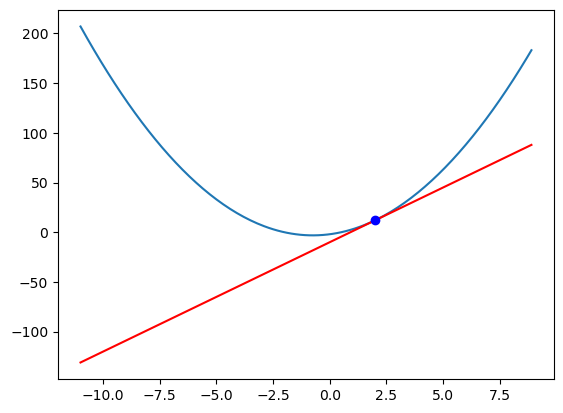

In [17]:
# 1.导数与梯度：函数上某一点的导数值的几何含义就是函数在该点上切线的斜率
x = np.arange(-11, 9, 0.1)
y = 2 * x ** 2 + 3 * x - 2
z = 11 * (x - 2) + 12  # x = 2时的切线方程
plt.plot(x, y, '-')
plt.plot(x, z, 'r-')
plt.plot(2, 12, 'bo')
plt.show()

对于一个函数，导数和切线的斜率的含义是给自变量的当前值一个无穷小的增量，自变量只能沿着切向方向移动（但仍然在曲线上），导数值的另外一个解释就是该点的梯度，梯度的值（grad）和导数相同，而梯度的概念可以视为导数概念的延伸，只不过梯度更侧重方向的概念，也就是从梯度的角度解读导数值，就代表着当前这个点的可以使得y值增加最快的移动方向。

梯度本身是一个代表方向的矢量，代表某一函数在该点处沿着梯度方向变化时，变化率最大：梯度的正方向代表函数值增长最快的方向，梯度的负方向表示函数减少最快的方向。

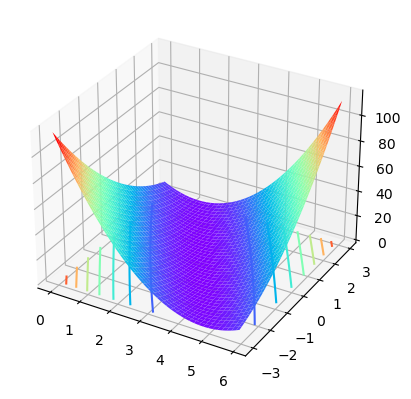

In [18]:
# 2.梯度与方向：简单线性回归的SSE函数的三维图像
x = np.arange(0, 6, 0.05)
y = np.arange(-3, 3, 0.05)
a, b = np.meshgrid(x, y)
SSE = lambda a, b: (3 - a - b) ** 2 + (6 - 2 * a - b) ** 2  # 目标函数
sse = SSE(a, b)
ax = plt.axes(projection='3d')
ax.plot_surface(a, b, sse, cmap='rainbow')
ax.contour(a, b, sse, zdir='z', offset=0, cmap='rainbow')  # 生成z方向投影，投到x-y平面
plt.show()

In [19]:
# 参数a、b在实数域上取值，假设均初始化为0、0
a = torch.tensor(0., requires_grad=True)
b = torch.tensor(0., requires_grad=True)
sse = SSE(a, b)
sse.backward()
a.grad, b.grad  # 得到的是一个向量，代表方向

(tensor(-30.), tensor(-18.))

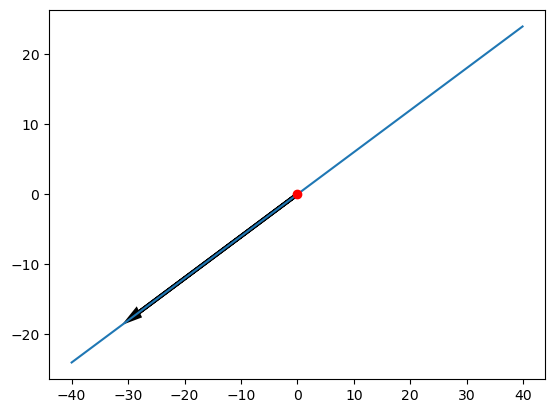

In [20]:
# 得到的梯度组成的方向向量是使得sse变化最快的方向，并且朝向(-30, -18)方向是使得sse增加最快的方向，反方向(30, 18)则是令sse减少最快的方向
# 通过绘制直线，确定移动的方向
x = np.arange(-40, 40, 0.1)
y = 18 / 30 * x
plt.plot(x, y, '-')
plt.plot(0, 0, 'ro')
plt.arrow(0, 0, -30, -18, head_width=1, head_length=2, lw=3, fc='r', length_includes_head=True)
plt.show()  # 梯度的方向为左下，则梯度的反方向为右上，即点应该向右上方(30, 18)移动

方向的特性：
- 方向没有大小
- 方向随着梯度，在随时发生变化：值得注意的是，一旦点发生移动，梯度就会随之发生变化

In [21]:
# 3.梯度与步长：步长也成为学习率
# 第1次移动
step = 0.01
grads = [a.grad, b.grad]
a = torch.tensor(a.item() - step * grads[0], requires_grad=True)
b = torch.tensor(b.item() - step * grads[1], requires_grad=True)
sse = SSE(a, b)
sse.backward()
a, b, a.grad, b.grad

(tensor(0.3000, requires_grad=True),
 tensor(0.1800, requires_grad=True),
 tensor(-25.9200),
 tensor(-15.4800))

In [22]:
# 第2次移动
grads = [a.grad, b.grad]
a = torch.tensor(a.item() - step * grads[0], requires_grad=True)
b = torch.tensor(b.item() - step * grads[1], requires_grad=True)
sse = SSE(a, b)
sse.backward()
a, b, a.grad, b.grad

(tensor(0.5592, requires_grad=True),
 tensor(0.3348, requires_grad=True),
 tensor(-22.3992),
 tensor(-13.3056))

可以看到，点第一次从(0, 0)移动到(0.3, 0.18)，第二次从(0.3, 0.18)移动到(0.5592, 0.3348)。同时，方向也在发生变化，无论移动“多小”一步，只要移动，方向就会更新。同时将移动的步长0.01称为学习率，而学习率乘以梯度，则是原点移动的“长度”。很明显，此时梯度还不为0，还没有到全域最优解，因此还需要以指定的学习率继续移动，直到逼近真实值(3, 0)为止。
## 4.梯度下降的数学表示
梯度下降有2种表示方式：
- 代数表示：$w_i = w_i - \alpha \frac{\partial}{\partial w_i}L(w_1, w_2..., w_d, b)$
- 矩阵表示：$\hat w = \hat w - \alpha \frac{\partial}{\partial \hat w}L(\hat w) = \hat w - \frac{\alpha}{m}X^T(X\hat w ^T - Y)$

不难发现，如果损失函数是凸函数，并且全域最小值存在，则步长可以表示当前点和最小值点之间距离的比例关系。同时，对于步长的设置，有如下初步结论：
- 步长太短：会极大的影响迭代收敛的时间，整体**计算效率会非常低**
- 步长太长：容易跳过最优解，导致**结果震荡**

关于步长的设置，其实更多会和实际使用情况相关，和实际损失函数特性相关。

## 5.手动实现梯度下降
用矩阵形式的梯度下降公式围绕前面的简单线性回归的目标函数，利用PyTorch的AutoGrad模块中的梯度计算功能，来进行手动求解梯度下降。

In [23]:
# 特征张量
X = torch.tensor([[1., 1], [2, 1]], requires_grad=True)
# 因变量
y = torch.tensor([[3.], [6]], requires_grad=True)
# 初始化权重参数
weights = torch.zeros(2, 1, requires_grad=True)
# 设置步长
step = 0.01
# 梯度计算公式
grad = X.t() @ (X @ weights - y) / X.size(0)
grad  # (-7.5, -4.5) = (-30, -18) / (2 * 2)

tensor([[-7.5000],
        [-4.5000]], grad_fn=<DivBackward0>)

In [24]:
# 更新权重参数：第一次更新
weights = weights - step * grad
weights

tensor([[0.0750],
        [0.0450]], grad_fn=<SubBackward0>)

In [25]:
# 迭代多轮
for i in range(10):
    grad = X.t() @ (X @ weights - y) / X.size(0)
    weights = weights - step * grad
weights

tensor([[0.6982],
        [0.4167]], grad_fn=<SubBackward0>)

In [26]:
for i in range(100):
    grad = X.t() @ (X @ weights - y) / X.size(0)
    weights = weights - step * grad
weights

tensor([[2.1901],
        [1.2093]], grad_fn=<SubBackward0>)

In [27]:
for i in range(1000):
    grad = X.t() @ (X @ weights - y) / X.size(0)
    weights = weights - step * grad
weights

tensor([[2.6314],
        [0.5964]], grad_fn=<SubBackward0>)

In [28]:
for i in range(10000):
    grad = X.t() @ (X @ weights - y) / X.size(0)
    weights = weights - step * grad
weights  # 已经逼近(3, 0)

tensor([[2.9997e+00],
        [4.1936e-04]], grad_fn=<SubBackward0>)

In [29]:
# 自定义梯度下降的函数
def gradient_descent(X, y, step=0.01, num_iteration=1000):
    weights = torch.zeros(X.size(1), 1, requires_grad=True)
    for _ in range(num_iteration):
        grad = X.t() @ (X @ weights - y) / X.size(0)
        weights = weights - step * grad
    return weights

In [30]:
X = torch.tensor([[1., 1], [2, 1]], requires_grad=True)
y = torch.tensor([[3.], [6]], requires_grad=True)
weights = gradient_descent(X, y, step=0.1, num_iteration=5000)
weights

tensor([[3.0000e+00],
        [7.2652e-06]], grad_fn=<SubBackward0>)

In [31]:
# 代入验证计算SSE：两种方式验证结果基本一致
SSE(weights[0][0], weights[1][0]), (y - X @ weights).t() @ (y - X @ weights)

(tensor(1.1394e-11, grad_fn=<AddBackward0>),
 tensor([[1.1369e-11]], grad_fn=<MmBackward0>))